In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [406]:
import matplotlib

In [402]:
from MiSciCNet_tools import *
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
dtype = torch.float32
import scipy.io
import scipy.linalg



In [ ]:
path='generated HSI/'
files=os.listdir(path)
Y_list=[]
abundances=[]
for file in files:
    fname  = path+file
    mat = scipy.io.loadmat(fname2)
    A = mat["A"]
    Y = mat["Y"]
    abundances.append(A)
    Y_list.append(Y)
dataset=np.array(Y_list)

In [7]:
[p1, nr1, nc1] = Y_list[0].T.shape
rmax=5  # number of pure endmembers

In [340]:
Y_list=np.array(dataset)

In [342]:
n=Y_list.shape[1]
rmax=5

In [344]:
p1=Y_list.shape[-1]
nr1=Y_list.shape[1]
nc1=Y_list.shape[2]
def process_patches(images, n):
    """
    Processes a list of image to extract noisy images, endmembers, and prepare inputs for a neural network.
    
    Args:
        images: A list of image (each image is a numpy array).
        n: height of the image
    
    Returns:
        imgs_torch: A list of tensors representing the HSi images.
        net_inputs1: A list of HSI images as inputs for the network.
        Es_torch: A list of tensors representing the extracted endmembers for each patch.
    """
    
    # Initialization
 
    net_inputs1 = []
    Es_torch = []
    imgs_torch=[]
  

    input_depth = images[0].T.shape[0]
    
    for i in range(len(images)):

        img = images[i].T  
        img_resh = img.reshape(p1, n * n)  

        # Perform Singular Value Decomposition (SVD) on the reshaped image
        V, SS, U = np.linalg.svd(img_resh, full_matrices=False)
       

        # Perform dimensionality reduction using the first rmax principal components
        img_resh_DN = V[:, :rmax] @ V[:, :rmax].T @ img_resh  # Apply dimensionality reduction
        img_resh_np_clip = np.clip(img_resh_DN, 0, 1)  # Clip values to the range [0, 1] (image pixel values)

        # Extract endmembers from the reduced image 
        II, III = Endmember_extract(img_resh_np_clip, rmax)
        E_np1 = img_resh_np_clip[:, II]  # Select the endmembers from the reduced image

        # Convert the denoised image to a PyTorch tensor and reshape it
        img_torch = torch.from_numpy(img_resh_DN).view(1, p1, nr1, nc1)
        imgs_torch.append(img_torch) 


        net_inputs1.append(img)  

        E_torch = torch.from_numpy(E_np1).type(dtype)
        Es_torch.append(E_torch)  
    
    # Return the processed results: original images, processed network inputs, and endmembers
    return imgs_torch, net_inputs1, Es_torch


In [348]:
a=np.transpose(Y_list, (0, 3, 1, 2))
a.shape

(95, 113, 307, 307)

In [ ]:
def my_loss(target, End2, lamb, out_):
    """
    Loss function 
    
    Args:
        target: The target tensor (ground truth) (real image)
        End2: A tensor representing the endmembers extracted in the current process.
        lamb: A scalar penalty to scale the endmember loss in the final combined loss.
        out_: The output tensor generated by the model to be compared to the target.
    
    Returns:
        loss1: The reconstruction loss (Frobenius norm).
        loss2: The endmember loss (based on simplex volume minimization).
        loss_total: The total loss, which is a weighted sum of the reconstruction and endmember losses.
    """
    

    target = target.clone().detach().requires_grad_(True)

    # Reconstruction Loss (loss1): 
    loss1 = 0.5 * torch.norm((out_.transpose(1, 0).view(1, p1, nr1, nc1) - target), 'fro').pow(2)
    
    # Endmember Loss (loss2): Minimization of simplex volume
  
    O = torch.mean(target.view(p1, nr1 * nc1), 1).type(dtype).view(p1, 1)  # mean of pixels
    B = torch.eye(rmax, dtype=dtype, requires_grad=True)
    loss2 = torch.norm(torch.mm(End2, B.view((rmax, rmax))) - O, 'fro') ** 2

    return loss1, loss2, loss1 + lamb * loss2

In [354]:
tol2=1
from tqdm import tqdm
INPUT = 'noise' 
pad = 'reflection'
need_bias=True
OPT_OVER = 'net' 
LR1 = 0.001  # learning rate
exp_weight=0.99 # weight coefficient
input_depth =Y_list[0].T.shape[0]

class CAE_EndEst(nn.Module):
            def __init__(self):
                super(CAE_EndEst, self).__init__()
                #encoder
                self.conv1 = nn.Sequential( 
                    conv(input_depth, p1,3,1,bias=need_bias,pad=pad),
                    nn.BatchNorm2d(p1,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv2 = nn.Sequential(
                    conv(p1, p1,3,1,bias=need_bias,pad=pad),
                    nn.BatchNorm2d(p1,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv3 = nn.Sequential(                            # skip connection
                    conv(input_depth, 4, 1,1,bias=need_bias,pad=pad),
                    nn.BatchNorm2d(4,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                # decoder 
                self.dconv2 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(117, p1, 3,1,bias=need_bias,pad=pad),
                    nn.BatchNorm2d(p1,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
        
                self.dconv3 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(p1, rmax, 3,1,bias=need_bias,pad=pad),
                    nn.BatchNorm2d(rmax,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.Softmax(dim=1),
                )
                self.dconv4 = nn.Sequential(
                    nn.Linear(rmax, p1,bias=False),
                )
            def forward(self, x):
                x1 = self.conv3(x)
                x = self.conv1(x)
                x = torch.cat([x,x1], 1)
                x = self.dconv2(x)
                x2 = self.dconv3(x)
                x3 = torch.transpose(x2.view((rmax,nr1*nc1)),0,1)
                x3 = self.dconv4(x3)
                return x2,x3

net1 = CAE_EndEst()
 
net1.train      


<bound method Module.train of CAE_EndEst(
  (conv1): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(113, 113, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): BatchNorm2d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(113, 113, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): BatchNorm2d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(113, 4, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (dconv2): Sequential(
    (0): Upsample(scale_factor=1.0,

In [360]:
p11 = get_params(OPT_OVER, net1, a)
                
optimizer = torch.optim.Adam(p11, lr=LR1, betas=(0.9, 0.999), eps=1e-8,
                     weight_decay= 0, amsgrad=False)

In [362]:
import warnings
warnings.simplefilter("ignore")

In [364]:
import random

In [368]:

out_avg = True
lamb = 0.05
def closure1(lamb, net_input):
    """
    lamb: penalty coefficient for the simplex volume minimization.
    net_input: input image (image to be processed).

    Returns:
    total_loss: The overall loss computed from the reconstruction and regularization (endmember) losses.
    """
    
    # Global variables 
    global i, out_LR_np, out_avg, out_avg_np, Eest

    out_LR, out_spec = net1(net_input)  # 'out_LR' is predicted abundances, 'out_spec' is the reconstructed image
    
    # Exponentially weighted average of the outputs (for stability or smoothing over iterations)
    if out_avg is None:  
        out_avg = out_LR.detach()  
    else:
        # Update out_avg with exponential smoothing
        out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)
    
    # Compute loss using'my_loss' function
    loss1, loss2, total_loss = my_loss(img_noisy_torch, net1.dconv4[0].weight, lamb, out_spec)

    total_loss.backward()  

    return loss1, loss2, total_loss


In [370]:
epochs=200

In [372]:
X_train=Y_list[:40]
X_val=Y_list[40:49]
X_test=Y_list[-1]

y_train=X_list[:40]
y_val=X_list[40:49]
y_test=X_list[-1]

In [376]:
avg_losses_train=[]
train_losses1=[]
train_losses2=[]

val_LOSSES = []  
val_LOSSES1=[]
val_LOSSES2=[]

for j in tqdm(range(epochs)):
        LOSSES=[]
        val_LOSSES=[]
        random.shuffle(X_train)   # shuffle image in each epoch
        for ind in range(len(X_train)):

                optimizer.zero_grad()
                net_input=X_train[ind].T.reshape(1,X_train[0].T.shape[0],X_train[0].T.shape[1],-1)
                img_noisy_torch,net_inputs,E_torch=process_patches(net_input,n) # E_torch extracted with endmemebers_extract
                                                                                # guide the unmixing network
                img_noisy_torch=img_noisy_torch[0]
                E_torch=E_torch[0]

                net1.dconv4[0].weight=torch.nn.Parameter(E_torch.view(p1,rmax))       
                optimizer.zero_grad()
                loss1,loss2,total_loss=closure1(lamb,torch.tensor(torch.tensor(net_input,dtype=torch.float32)))
                train_losses1.append(float(loss1))
                train_losses2.append(float(loss2))
                LOSSES.append(float(total_loss))
                optimizer.step()
                net1.dconv4[0].weight.data[net1.dconv4[0].weight <= 0] = 0  # weights between 0 and 1
                net1.dconv4[0].weight.data[net1.dconv4[0].weight >= 1] = 1  # weights between 0 and 1
                if j>0:
                    Eest=net1.dconv4[0].weight.detach().cpu().squeeze().numpy()   # Weights as estimated endmembers
        avg_loss_epoch = np.mean(np.array(LOSSES))
        avg_losses_train.append(avg_loss_epoch)
        print(f"Epoch {j+1}/{epochs} - Loss: {avg_loss_epoch}")
        


        for ind in range(len(X_val)):   # Validation
                net_input1 = X_val[ind].T.reshape(1, X_val[0].T.shape[0], X_val[0].T.shape[1], -1)
                img_noisy_torch, net_inputs1, E_torch = process_patches(net_input1, n)
                img_noisy_torch = img_noisy_torch[0]
                E_torch = E_torch[0]
  
                with torch.no_grad():
                    net1.dconv4[0].weight.data.copy_(E_torch.view(p1, rmax))

                loss1, loss2, total_loss = closure1(lamb, torch.tensor(net_input1, dtype=torch.float32))
                val_LOSSES.append(float(total_loss))
                val_LOSSES1.append(float(loss1))
                val_LOSSES2.append(float(loss2))
        val_loss_epoch = np.mean(np.array(val_LOSSES))
        val_LOSSES.append(val_loss_epoch)
        print(f"Validation Loss: {val_loss_epoch}")

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 - Loss: 56736.489031006444


  0%|▍                                                                           | 1/200 [38:34<127:55:28, 2314.21s/it]

Validation Loss: 62733.26471586705
Epoch 2/200 - Loss: 58367.92928925203


  1%|▋                                                                         | 2/200 [1:04:01<101:48:37, 1851.10s/it]

Validation Loss: 62791.16325529759
Epoch 3/200 - Loss: 59535.324162952995


  2%|█▏                                                                         | 3/200 [1:29:10<92:45:56, 1695.21s/it]

Validation Loss: 62910.392167837745
Epoch 4/200 - Loss: 61813.510697932914


  2%|█▌                                                                         | 4/200 [1:53:03<86:38:44, 1591.45s/it]

Validation Loss: 63095.26648847501
Epoch 5/200 - Loss: 60611.85407485576


  2%|█▊                                                                        | 5/200 [2:38:10<107:59:37, 1993.73s/it]

Validation Loss: 63334.438456177646
Epoch 6/200 - Loss: 62588.4987821124


  3%|██▎                                                                        | 6/200 [3:03:32<98:47:32, 1833.26s/it]

Validation Loss: 63609.27054300091
Epoch 7/200 - Loss: 63666.33661150711


  4%|██▋                                                                        | 7/200 [3:27:57<91:50:01, 1712.96s/it]

Validation Loss: 64419.06004474013
Epoch 8/200 - Loss: 63424.95323380558


  4%|███                                                                        | 8/200 [3:51:43<86:28:55, 1621.54s/it]

Validation Loss: 66935.09247990172
Epoch 9/200 - Loss: 63202.872497478806


  4%|███▍                                                                       | 9/200 [4:15:08<82:26:55, 1554.01s/it]

Validation Loss: 67542.0645288956
Epoch 10/200 - Loss: 63064.79452398431


  5%|███▋                                                                      | 10/200 [4:38:16<79:19:06, 1502.87s/it]

Validation Loss: 67292.99968039834
Epoch 11/200 - Loss: 62923.131720823774


  6%|████                                                                      | 11/200 [5:00:44<76:24:03, 1455.25s/it]

Validation Loss: 67333.95062360344


  6%|████                                                                      | 11/200 [5:17:19<90:52:21, 1730.91s/it]


KeyboardInterrupt: 

In [105]:
train_loss1=train_losses1[:-30]
train_loss2=train_losses2[:-30]
val_loss1=val_LOSSES1
val_loss2=val_LOSSES2
#val_loss=val_LOSSES[:-3]

In [107]:
train_loss1 = np.array(train_loss1)
train_loss1 = np.mean(train_loss1.reshape(-1, 40), axis=1)
train_loss1 = train_loss1.tolist()

train_loss2 = np.array(train_loss2)
train_loss2 = np.mean(train_loss2.reshape(-1, 40), axis=1)
train_loss2 = train_loss2.tolist()

#val_loss = np.array(val_loss)
#val_loss = np.mean(val_loss.reshape(-1, 9), axis=1)
#val_loss = val_loss.tolist()

val_loss1 = np.array(val_loss1)
val_loss1 = np.mean(val_loss1.reshape(-1, 9), axis=1)
val_loss1= val_loss1.tolist()

val_loss2 = np.array(val_loss2)
val_loss2 = np.mean(val_loss2.reshape(-1, 9), axis=1)
val_loss2= val_loss2.tolist()

val_loss=val_loss1+val_loss2

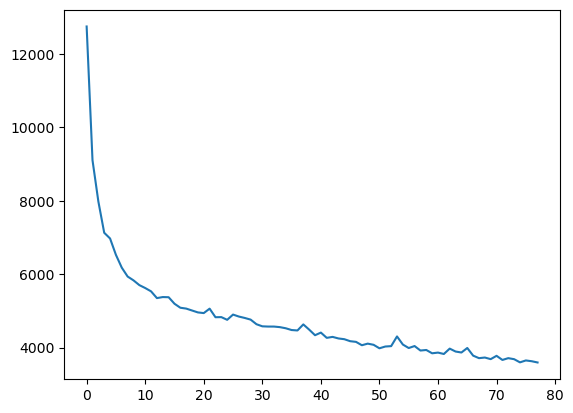

In [121]:
plt.plot(train_loss1)

In [127]:
val_losses = val_losses.reshape(-1, 10).mean(axis=1)

In [151]:
val_losses1 = np.array(val_losses1).reshape(-1, 10).mean(axis=1)
val_losses2 = np.array(val_losses2).reshape(-1, 10).mean(axis=1)

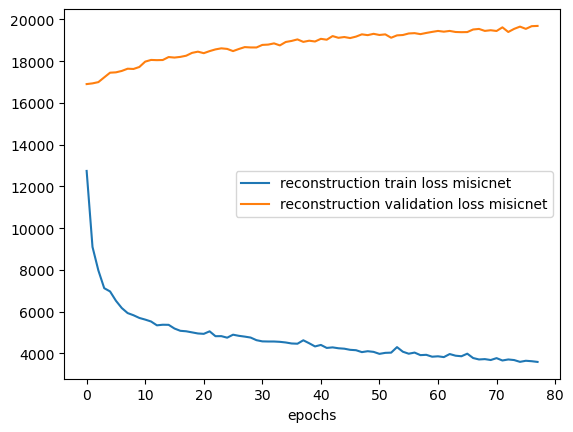

In [127]:
plt.plot(train_loss1 ,label='reconstruction train loss misicnet')
plt.plot(val_loss1 ,label='reconstruction validation loss misicnet')
plt.xlabel('epochs')
plt.legend()
plt.show()

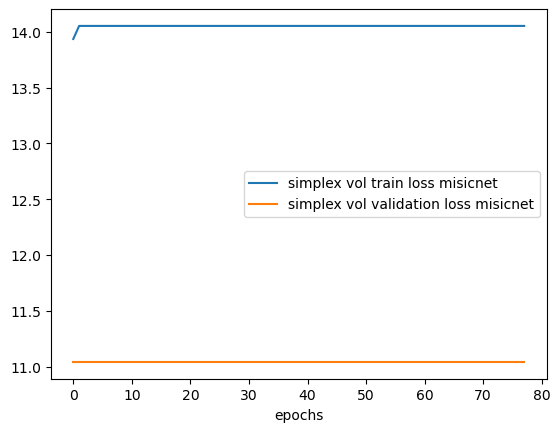

In [125]:

plt.plot(train_loss2 ,label='simplex vol train loss misicnet')
plt.plot(val_loss2 ,label='simplex vol validation loss misicnet')
plt.xlabel('epochs')
plt.legend()
plt.show()

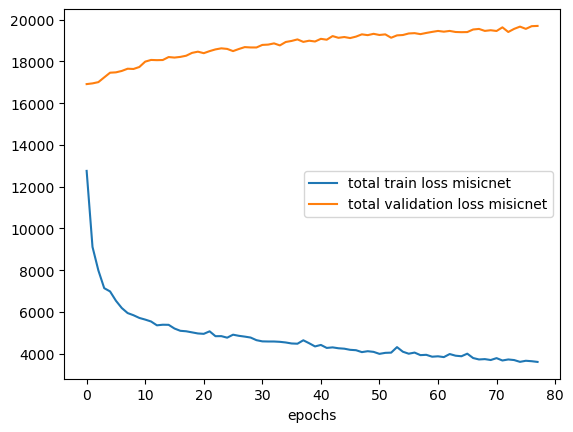

In [219]:
plt.plot(np.array(train_loss2)+np.array(train_loss1) ,label='total train loss misicnet')
plt.plot(np.array(val_loss2)+np.array(val_loss1) ,label='total validation loss misicnet')
plt.xlabel('epochs')
plt.legend()
plt.show()

95

In [151]:
X_test.shape

(128, 128, 113)

In [378]:
X_test_=torch.tensor(X_test,dtype=torch.float32).unsqueeze(0)
X_test_=X_test_.permute(0,3,1,2)

torch.Size([1, 113, 307, 307])

In [384]:
inp=X_test_
out,_=net1(inp)
pred_abu=out[0].detach().numpy()

In [390]:
true_abundances=y_test
true_abundances.shape

(128, 128, 5)

In [311]:
img = torch.tensor(patches[ind], dtype=torch.float32)

In [313]:
inp=torch.tensor(img.T.reshape(1,img.T.shape[0],img.T.shape[1],-1),dtype=torch.float32)
out,_=net1(inp)
abun=out[0].detach().numpy()

In [396]:
abundances[-1].shape

(307, 307, 4)

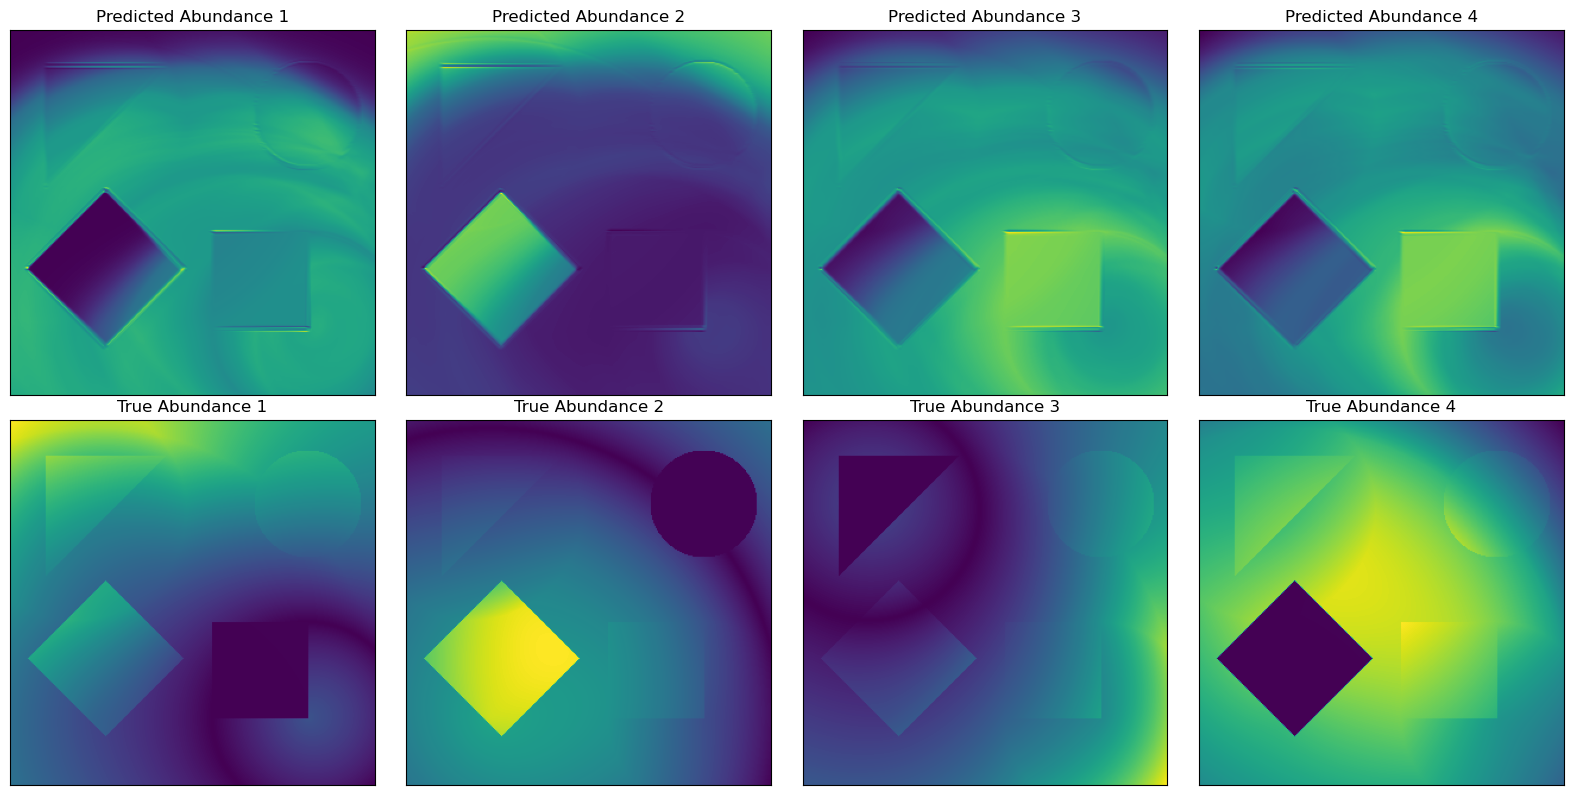

In [398]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 4, figsize=(16, 8)) 


for i in range(4):
    axes[0, i].imshow(pred_abu[i])
    axes[0, i].set_title(f"Predicted Abundance {i+1}")
    axes[0, i].set_xticks([])  
    axes[0, i].set_yticks([])


for i in range(4):
    axes[1, i].imshow(abundances[-1][:, :, i])
    axes[1, i].set_title(f"True Abundance {i+1}")
    axes[1, i].set_xticks([])  
    axes[1, i].set_yticks([])


plt.tight_layout()
plt.savefig("heatmaps.png", dpi=300, bbox_inches='tight')
plt.show()
